# Bayesian estimation of distinguishability of homogeneous diffusion constants from trajectories

This notebook gives example analysis for how to use and interact with the n_dim_homogeneous_distinguishability.py package.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# import bayesian estimation package
import ndim_homogeneous_distinguishability as hd

## Simulating homogeneous diffusion trajectories with localization error

First, let's generate a noiseless simulated diffusive trajectory in 2D, with 10 steps at a frame rate of 1 second, with diffusion constant of 0.01 um2/s:

In [2]:
df1 = hd.simulate_diffusion_df(n_dim = 2, d_const = 0.01, n_steps = 100, dt = 1, loc_std = 0.03)
df1.head()

,dr,dr_obs,dx,dx_obs,t_step,x,x_obs
0,0.231133,0.216181,"[-0.2200139669888102, -0.07082709346424965]","[-0.20751842078554616, -0.06058208793052019]",0.0,"[0.0, 0.0]","[-0.02662185583822665, 0.007480114631813213]"
1,0.080558,0.084086,"[-0.03320783341352358, 0.07339514651625972]","[-0.07213731177074509, 0.04320420512823691]",1.0,"[-0.2200139669888102, -0.07082709346424965]","[-0.23414027662377282, -0.05310197329870697]"
2,0.136866,0.151141,"[-0.006197404972982684, -0.13672569323763775]","[0.04535193088662648, -0.14417656045847918]",2.0,"[-0.2532218004023338, 0.0025680530520100775]","[-0.3062775883945179, -0.009897768170470065]"
3,0.260641,0.295882,"[-0.22492797455299937, 0.1316857526439636]","[-0.2626903140923792, 0.13616055159661392]",3.0,"[-0.2594192053753165, -0.13415764018562767]","[-0.26092565750789143, -0.15407432862894924]"
4,0.187626,0.245205,"[0.12012344869290051, -0.14413163361983]","[0.16431010617865827, -0.18201020428011172]",4.0,"[-0.4843471799283159, -0.0024718875416640806]","[-0.5236159716002706, -0.017913777032335317]"


This created a trajectory with true positions x (each with two components because we chose to generate a trajectory in 2D) and observed positions x_obs, which are slightly different from x because we included localization error. The dx and dx_obs series contain the dimensionwise displacements (true and observed) whereas dr and dr_obs contain their absolute magnitudes (framewise step sizes). What do these trajectories look like? Let's plot them to see.

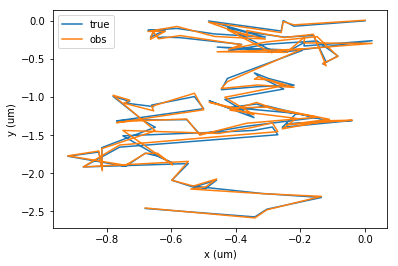

In [3]:
plt.plot([x[0] for x in df1['x']], [x[1] for x in df1['x']], label='true')
plt.plot([x[0] for x in df1['x']], [x[1] for x in df1['x_obs']], label='obs');
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.legend()

## Estimating the underlying diffusion constant using bayesian inference

Imagining we don't know the real answer, can we use the set of step sizes to predict what the underlying diffusion constant was? Let's generate a posterior distribution for this set of (noisy) step sizes by passing them into our estimation method. Because we are predictin the variance of a nromal distribution with known mean, a inverse gamma function (parameterized by 'alpha' and 'beta' as a conjugate prior (https://en.wikipedia.org/wiki/Normal_distribution#With_known_mean).

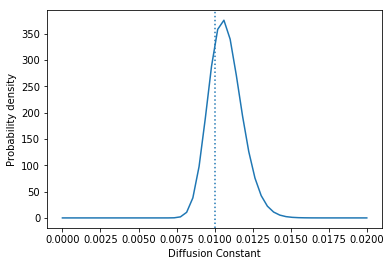

In [4]:
posterior, alpha, beta = hd.estimate_diffusion(n_dim = 2, dt = 1, dr = df1['dr_obs'])
xx = np.linspace(0,0.02, 50)
plt.plot(xx, posterior.pdf(xx))
plt.axvline(x=0.01, linestyle=':')
plt.xlabel('Diffusion Constant')
plt.ylabel('Probability density');

Side note: there is also a single function which performs both the simulation and esimation steps in a single step ('generate_posterior). This seemingly redundant function was written for the sake of parallel processing, which requires a single function call. For example, if for statistical reasons, I was interested in how the posteriors would vary if I reran the above analysis many times, I could do so using a parallelized function that returns the list of all values for the posterior parameters alpha and beta for each rerun of the simulation, as well as their median values.

Median beta value: 1.0369121152294314


/home/juliec/miniconda3/envs/trans_env/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


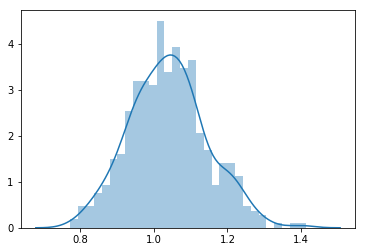

In [5]:
alpha_median, beta_median, alphas, betas = hd.get_posterior_set(n_dim=2, d_const=0.01, n_steps=100, dt=1, n_reps=500, loc_std=0.02)
print('Median beta value: '+str(beta_median))
sb.distplot(betas, bins=30);

Back to our single posterior. How far off was this estimate? Let's calculate the percent error between the mean of this distribution and the true diffusion constant.

In [6]:
print('percent error = '+str(100*((posterior.mean() - 0.01)/0.01)))
# calculate percent error of posterior relative to true diffusion constant value

percent error = 7.417133774658309


Now let's say I want to compare the posterior distributions I get for two trajectories with identical parameterizations but different diffusion constants (i.e. same number of spatial dimensions, same length, tmeporal resolution and localization error). I can generate and view a single posterior for these two trajectoires with diffusion constants D1 and D2=mult*D1 using a comparison method.

## Comparing posteriors for trajectories with differing underlying diffusion constants

KL div: 14.00764409814667
Inverse: 0.07138959221074931


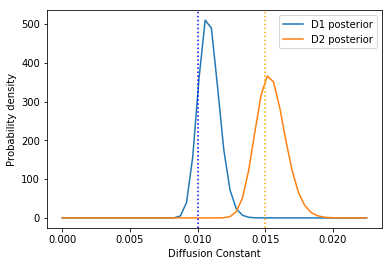

In [7]:
hd.compare2(n_dim=3, d_const1=0.01, mult=1.5, n_steps=200, dt=1, n_reps=10, loc_std = 0.03)

This method also printed out for us the KL divergence between these two distributions, and its inverse, calculated using the 'invgamma_kldiv' function, based on this reference: https://arxiv.org/pdf/1605.01019.pdf. The inverse of the KL divergence is useful for thinking about psoterior distributions, because it is approximately the number of times you could draw from one distribution in place of the other before there is a significant amount of information loss. This offers us a single measurement of our ability to distinguish whether there is a difference between the diffusion constants underlying these two input trajectories.

## Now let's repeat this for many pairs of diffusion constants, and trajectories of many lengths, to create an experimental "lookup table"

Given two trajectories, our ability to distinguish whether their underlying diffusion constants differ willbe limited by how similar or different those two diffusion constants are (the 'mult' parameter in the 'compare2' function above). It will also be limited by the accuracy of the diffusion constant estimates themselves; given shorter trajectory length, we will have less information and therefor less accurate diffsuion estimates than if we had longer trajectories. To quantitatively explore the combination of these effects, we create a heatmap of pairwise posterior KL divergences, conditional on both the trajectory length and the relative diffusivity values. Each pixel in the heatmap will be the median values from N reps of calculating the KL divergence of a pair of posteriors estimated for trajcetories with diffusion cosntants D1 and D2, with trajcetory length T.

In [ ]:
n_steps = [5, 25, 50, 100, 200, 500, 1000]
# set diffusion constant multipliers to sweep through (D2 = mult*D1)
d_const1 = 0.01
Mmin = 1.0
Mmax = 15.
numM = 30
mult_list = np.logspace(np.log10(Mmin), np.log10(Mmax), numM)

# set trajectory lengths, timestep, and number of rep's on each D
dt = 1
n_reps = 10**3

To see biologically relevant examples for diffusion constant orders of magnitude, check out BioNumbers:

http://book.bionumbers.org/what-are-the-time-scales-for-diffusion-in-cells/

In [ ]:
# get df of pairwise KL divergence for each pair (D, mult*D)
KL_sweep_df_T = hd.fill_heatmap_gen(n_dim=3, d_const=d_const1, mult_list=mult_list, n_steps=n_steps, dt=dt, n_reps=n_reps)

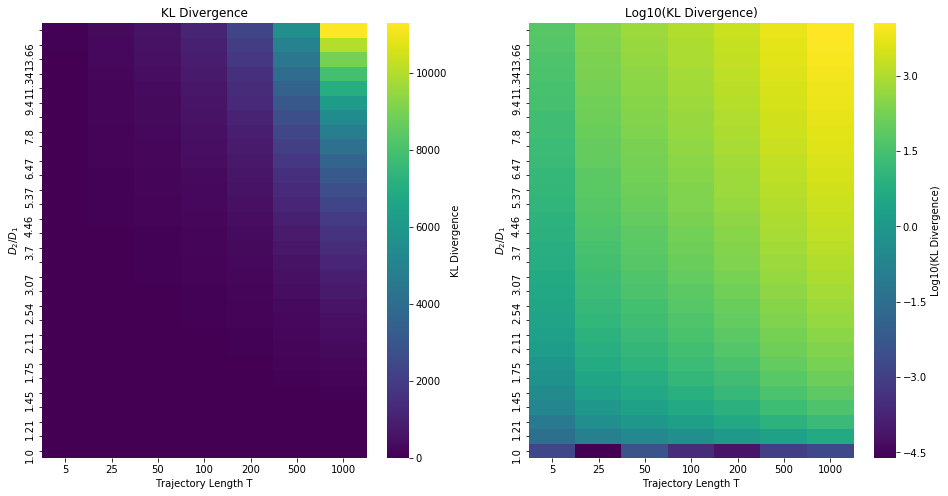

In [12]:
# and plot that df as a heatmap of KL divergence values, and the log of the KL divergence values
x_lab = 'Trajectory Length T'
y_lab = r'$D_2/D_1$'
t1 = 'KL Divergence'
t2 = 'Log10(KL Divergence)'
hd.plot_df_results(df1=KL_sweep_df_T, df2=np.log10(KL_sweep_df_T), n_round=2, n_ticks=12, size=8, title1=t1, title2=t2, x_lab=x_lab, y_lab=y_lab)

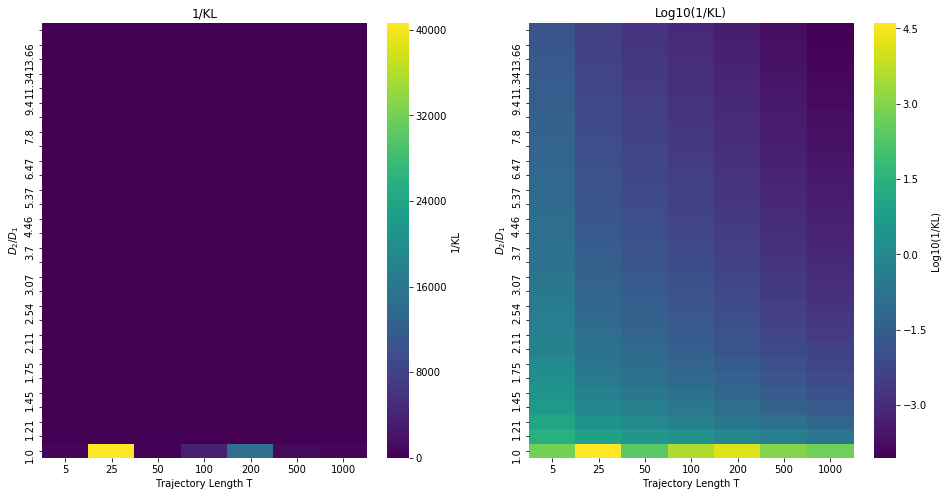

In [13]:
# now, let's look at the same results, but for the inverse of the KL divergence
t1 = '1/KL'
t2 = 'Log10(1/KL)'
dfT = 1/KL_sweep_df_T
hd.plot_df_results(df1=dfT, df2=np.log10(dfT), n_round=2, n_ticks=12, size=8, title1=t1, title2=t2, x_lab=x_lab, y_lab=y_lab)

## Localization error

### Distribution of percent errors in the posterior, for a given trajectory length and localization error

If we include localization error, how does it impact the error in our diffusion constant estimates, depending on number of spatial dimensions? To look into this, we select one set of simulation parameters and rerun the trajectory simulation and posterior estimation N times, and collect a histogram of the percent error of the predicted diffusion constant relative to the true value. We repeat this in 1, 2, and 3 dimensions with all other trajectory parameters unchanged; then we can compare the resulting histograms across dimensions and decide whether we see an effect.

In [8]:
d_const = 0.1
n_steps = 10**3
dt = 1
n_reps = 10**4
n_dim = [1, 2, 3]

Dim = 1: 0.04474572046481369 +- 0.00044719352864296515
Dim = 2: 0.11613818373153 +- 0.0003201066017927218
Dim = 3: 0.06431831947124196 +- 0.00026115190293317733


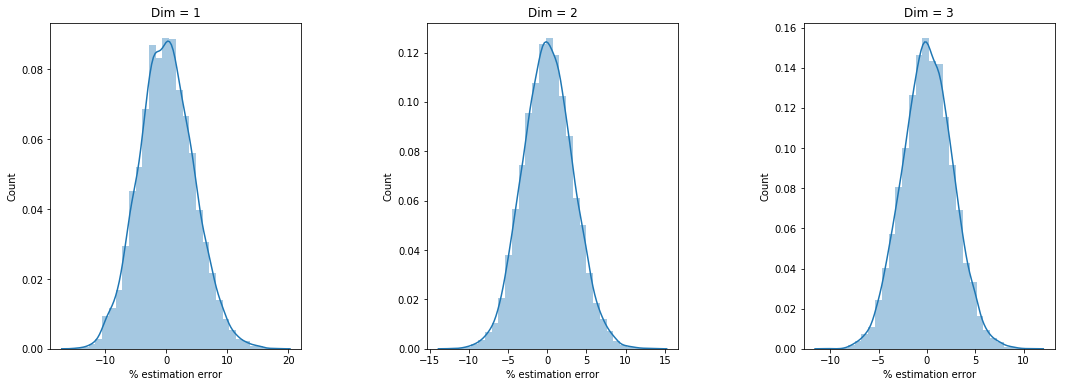

In [9]:
std_list = [0, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1]
p_error = np.load('loc_error_saved_files/std_'+str(std_list[2])+'.npy')
hd.show_error_hist(n_dim, p_error)

This was for a fixed amount of localization error. The dimensional effects on estimation error may be dependent on the amount of localization error. So instead, lets find the means above the above hisograms, and repeat for many values of localization error. As a result, we'll see a plot of the mean posterior estimation error as a function of the amount of localization error added, for each number of spatial dimensions.

In [10]:
std_list = [0, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1]
df_means = pd.DataFrame()
n_dim_extended = [1, 2, 3, 5, 10, 100, 1000]
for std in std_list:
    p_error = np.load('loc_error_saved_files/std_'+str(std)+'.npy')
    for dim_n in range(len(n_dim_extended)):
        df_means.loc[str(std),dim_n] = np.mean(p_error[dim_n-1])

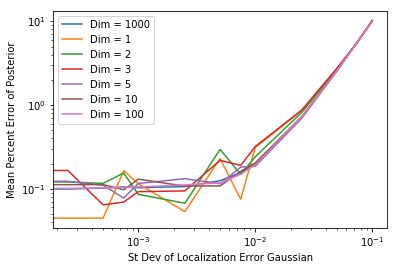

In [11]:
for n in range(len(n_dim_extended)):
    plt.plot(std_list, df_means[n], label='Dim = '+str(n_dim_extended[n-1]))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('St Dev of Localization Error Gaussian')
plt.ylabel('Mean Percent Error of Posterior')
plt.legend();

### Average percent error in posterior predictions, for many different trajetory lengths and levels of localization error

In each of the above we used a set trajectory length and standard deviation of localization error. Both of these contribute to the error in our posterior estimation. Let's look at how sensitive our error is to these pairs of parameters by looking at the average percent error over 10,000 repete trials for many different pairs of (trajectory length, error)

In [ ]:
df1, df2, df3 = hd.error_sensitivity(d_const=0.1, n_steps_list=[10, 25, 50, 100, 150, 200, 500], dt=1, n_reps=10**4, loc_std=[0, 0.005, 0.01, 0.025, 0.05, 0.1, 0.2])

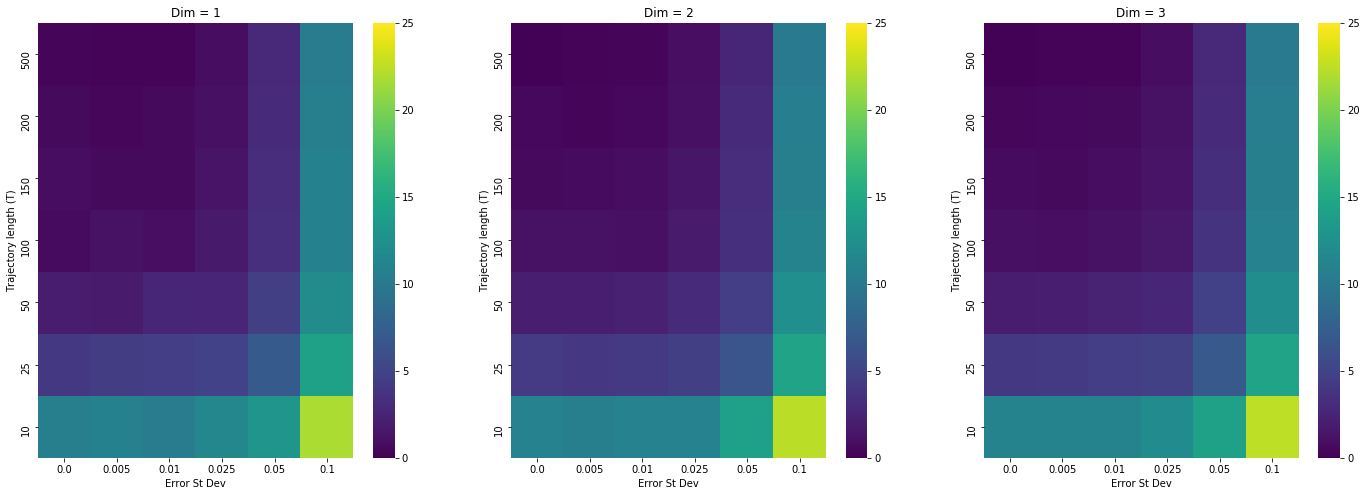

In [26]:
df11 = df1.drop(columns=df1.columns[6])
df22 = df2.drop(columns=df2.columns[6])
df33 = df3.drop(columns=df3.columns[6])

size = 8
fig4, axs = plt.subplots(1,3, figsize=(3*size,size))
    
sb.heatmap(df11, ax=axs[0], cmap='viridis', vmin=0, vmax=25);
axs[0].set(xlabel = 'Error St Dev', ylabel = 'Trajectory length (T)', title='Dim = 1');
axs[0].invert_yaxis()
    
sb.heatmap(df22, ax=axs[1], cmap='viridis', vmin=0, vmax=25);
axs[1].set(xlabel = 'Error St Dev', ylabel = 'Trajectory length (T)', title='Dim = 2');
axs[1].invert_yaxis()

sb.heatmap(df33, ax=axs[2], cmap='viridis', vmin=0, vmax=25);
axs[2].set(xlabel = 'Error St Dev', ylabel = 'Trajectory length (T)', title='Dim = 3');
axs[2].invert_yaxis()

### Differences by dimension

These all look quite similar on this scale. Let's look at their pairwise differences to see the impact of adding spatial dimensions on error.

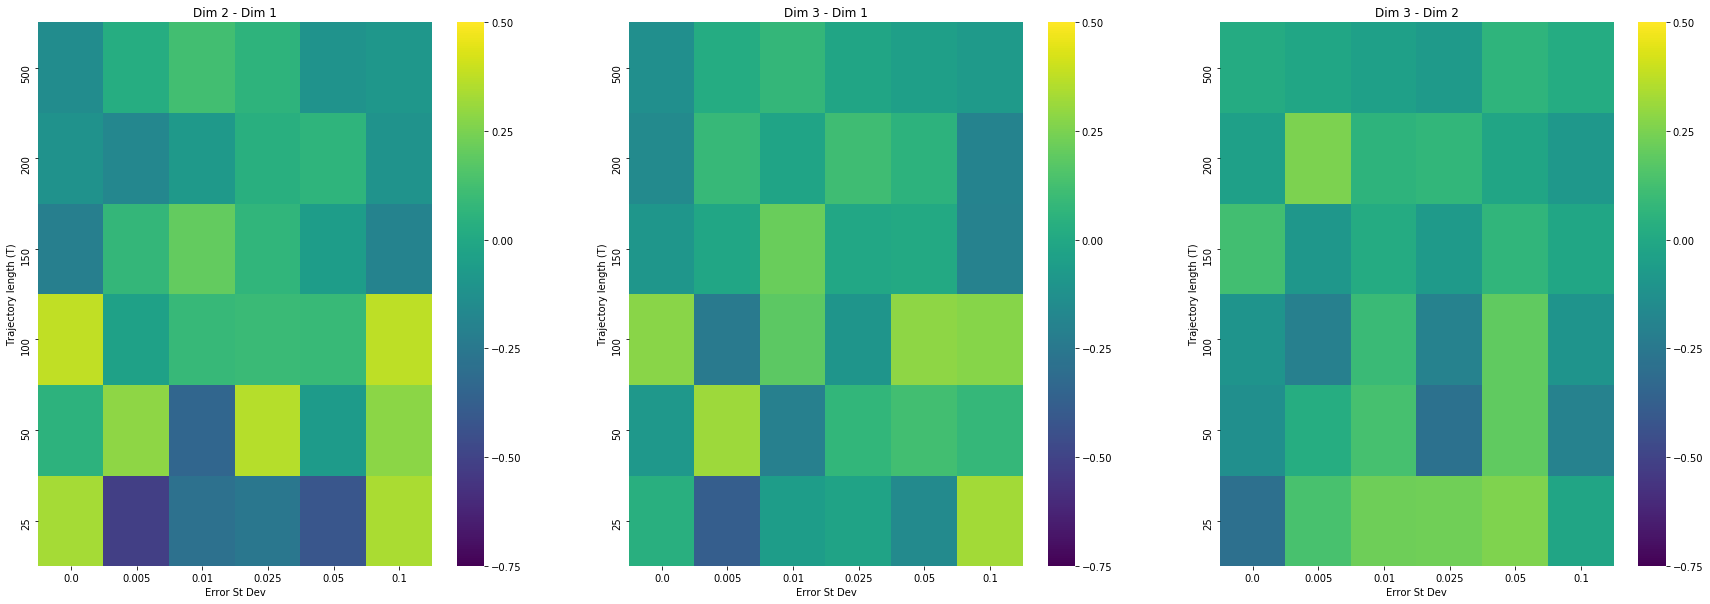

In [27]:
df12 = df22.subtract(df11)
df12 = df12.drop(index=df12.index[0])
df13 = df33.subtract(df11)
df13 = df13.drop(index=df13.index[0])
df23 = df33.subtract(df22)
df23 = df23.drop(index=df23.index[0])

size = 10
fig5, axs = plt.subplots(1,3, figsize=(3*size,size))
    
sb.heatmap(df12, ax=axs[0], cmap='viridis', vmin=-0.75, vmax=0.5);
axs[0].set(xlabel = 'Error St Dev', ylabel = 'Trajectory length (T)', title='Dim 2 - Dim 1');
axs[0].invert_yaxis()
    
sb.heatmap(df13, ax=axs[1], cmap='viridis', vmin=-0.75, vmax=0.5);
axs[1].set(xlabel = 'Error St Dev', ylabel = 'Trajectory length (T)', title='Dim 3 - Dim 1');
axs[1].invert_yaxis()

sb.heatmap(df23, ax=axs[2], cmap='viridis', vmin=-0.75, vmax=0.5);
axs[2].set(xlabel = 'Error St Dev', ylabel = 'Trajectory length (T)', title='Dim 3 - Dim 2');
axs[2].invert_yaxis()